In [1]:
import os
import sys
projectDir = '/mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam'
sys.path.append(projectDir)

import config as config
config.path_to_project = projectDir
config.path_to_data = os.path.join(projectDir, 'data', 'clean')
config.path_to_results = os.path.join(projectDir, 'results')
config.path_to_images = '/home/jul/DST/Rakuten/Data/images/image_train_resized'
config.path_to_models = '/mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models'



import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ImgClassifier
from src.multimodal.classifiers import TFmultiClassifier
from src.utils.plot import classification_results, plot_training_history

from sklearn.metrics import f1_score

2024-03-09 23:56:31.475989: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 23:56:31.528151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 23:56:31.528182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 23:56:31.530023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 23:56:31.541097: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_train = pd.read_csv(os.path.join(config.path_to_data, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(config.path_to_data, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0)

#merging text into token column
colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
data['tokens'] = data[colnames].apply(lambda row: ' '.join(s.lower() for s in row if isinstance(s, str)), axis=1)

#path to images into img_path column
data['img_path'] = Rakuten_img_path(img_folder=config.path_to_images,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')


In [3]:
#labels of encoded classes
class_labels = data.groupby('prdtypedesignation')['prdtypeindex'].first().reset_index()
class_labels.index = class_labels['prdtypeindex']
class_labels = class_labels.drop(columns='prdtypeindex').sort_index()

## Creating train and test sets

In [4]:
Img_train = data.loc[~data['testset'], 'img_path']
Img_test = data.loc[data['testset'], 'img_path']

Txt_train = data.loc[~data['testset'], 'tokens']
Txt_test = data.loc[data['testset'], 'tokens']

y_train = data.loc[~data['testset'],'prdtypeindex']
y_test = data.loc[data['testset'],'prdtypeindex']

#To be fed into any of our sklearn classifiers, X_train and X_test
#should be dataframes with columns tokens and img_path
X_train = pd.DataFrame({'tokens': Txt_train, 'img_path': Img_train})
X_test = pd.DataFrame({'tokens': Txt_test, 'img_path': Img_test})

#All data for cross-validated scores
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

#Number of classes
num_classes = len(np.unique(data['prdtypeindex']))

## BERT classifier

In [5]:
callbacks = [('EarlyStopping', {'monitor': 'val_accuracy', 'mode': 'max', 'min_delta': 0.001, 'patience': 2, 'restore_best_weights': True})] #try using a lr scheduler
model_bert = TFbertClassifier(base_name='camembert-base', from_trained=None, max_length=256, num_class=num_classes, epochs=8, batch_size=32, drop_rate=0.2, learning_rate=5e-5, validation_data=(X_test, y_test))#, validation_split=0.1, callbacks=callbacks)
# model_bert = TFbertClassifier(base_name='camembert/camembert-base-ccnet', max_length=256, num_class=num_classes, epochs=1, batch_size=32, drop_rate=0.2)


2024-03-09 16:50:08.510412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 16:50:08.510908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 16:50:08.628770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 16:50:08.628870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 16:50:08.628921: I external/local_xla/xla/stream_executor

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


loading weights from  Bert_ep8_lr5_10_5


In [ ]:
model_bert.fit(X_train, y_train);

Epoch 1/8


2024-03-08 11:35:12.763357: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-08 11:35:18.634279: I external/local_xla/xla/service/service.cc:168] XLA service 0x70f92440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-08 11:35:18.634395: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-08 11:35:18.634418: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-08 11:35:18.650616: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-08 11:35:19.332982: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709894119.513320  992100 device_compiler.h:186] Compil

2123/2123 [==============================] - 1557s 711ms/step - loss: 0.7932 - accuracy: 0.7840 - val_loss: 0.4907 - val_accuracy: 0.8523
Epoch 2/8
2123/2123 [==============================] - 1522s 717ms/step - loss: 0.4207 - accuracy: 0.8725 - val_loss: 0.4489 - val_accuracy: 0.8666
Epoch 3/8
2123/2123 [==============================] - 1512s 712ms/step - loss: 0.2969 - accuracy: 0.9095 - val_loss: 0.4494 - val_accuracy: 0.8746
Epoch 4/8
2123/2123 [==============================] - 1505s 709ms/step - loss: 0.2455 - accuracy: 0.9233 - val_loss: 0.4600 - val_accuracy: 0.8772
Epoch 5/8
2123/2123 [==============================] - 1522s 717ms/step - loss: 0.1791 - accuracy: 0.9445 - val_loss: 0.4826 - val_accuracy: 0.8819
Epoch 6/8
2123/2123 [==============================] - 1512s 712ms/step - loss: 0.1430 - accuracy: 0.9554 - val_loss: 0.6156 - val_accuracy: 0.8489
Epoch 7/8
2123/2123 [==============================] - 1511s 712ms/step - loss: 0.2700 - accuracy: 0.9184 - val_loss: 0.50

In [ ]:
model_bert.classification_score(X_test, y_test)

2024-03-08 16:35:11.943943: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 155s 275ms/step


0.8817062104281385

In [ ]:
model_bert.save(name='Bert_ep8_lr5_10_5')

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'epochs': [1]}

grid_bert = GridSearchCV(model_bert, param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_bert.fit(X_train, y_train)

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-03-06 23:28:59.563262: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 23:29:05.402286: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f86d807b5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 23:29:05.402335: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-06 23:29:05.402342: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-06 23:29:05.407460: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-06 23:29:06.070755: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709764146.233291 1582062 device_compiler.h:186] Co

32/32 [==============================] - 12s 272ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


32/32 [==============================] - 12s 272ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


32/32 [==============================] - 12s 265ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


32/32 [==============================] - 12s 264ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


32/32 [==============================] - 12s 264ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


157/157 [==============================] - 141s 637ms/step - loss: 2.1976 - accuracy: 0.4606


GridSearchCV(cv=5, estimator=TFbertClassifier(epochs=5),
             param_grid={'epochs': [1]}, scoring='f1_weighted')

In [ ]:
grid_bert.cv_results_

{'mean_fit_time': array([122.86499162]),
 'std_fit_time': array([2.4889013]),
 'mean_score_time': array([12.50902634]),
 'std_score_time': array([0.17889774]),
 'param_epochs': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'epochs': 1}],
 'split0_test_score': array([0.56474792]),
 'split1_test_score': array([0.58154055]),
 'split2_test_score': array([0.61091548]),
 'split3_test_score': array([0.60926626]),
 'split4_test_score': array([0.54057181]),
 'mean_test_score': array([0.58140841]),
 'std_test_score': array([0.02680278]),
 'rank_test_score': array([1], dtype=int32)}

In [ ]:
plot_training_history(model_bert.history)

              precision    recall  f1-score   support

           0       0.54      0.73      0.62       623
           1       0.81      0.75      0.78       534
           2       0.93      0.95      0.94       791
           3       0.75      0.37      0.50       153
           4       0.75      0.76      0.76       974
           5       0.73      0.53      0.61       414
           6       0.98      0.97      0.98      1009
           7       0.94      0.94      0.94       161
           8       0.82      0.77      0.79       498
           9       0.93      0.74      0.83       648
          10       0.81      0.88      0.84      1015
          11       0.90      0.91      0.90       861
          12       0.92      0.94      0.93       161
          13       0.79      0.80      0.79       999
          14       0.93      0.86      0.89       165
          15       0.86      0.92      0.89       952
          16       0.76      0.86      0.81       955
          17       0.78    

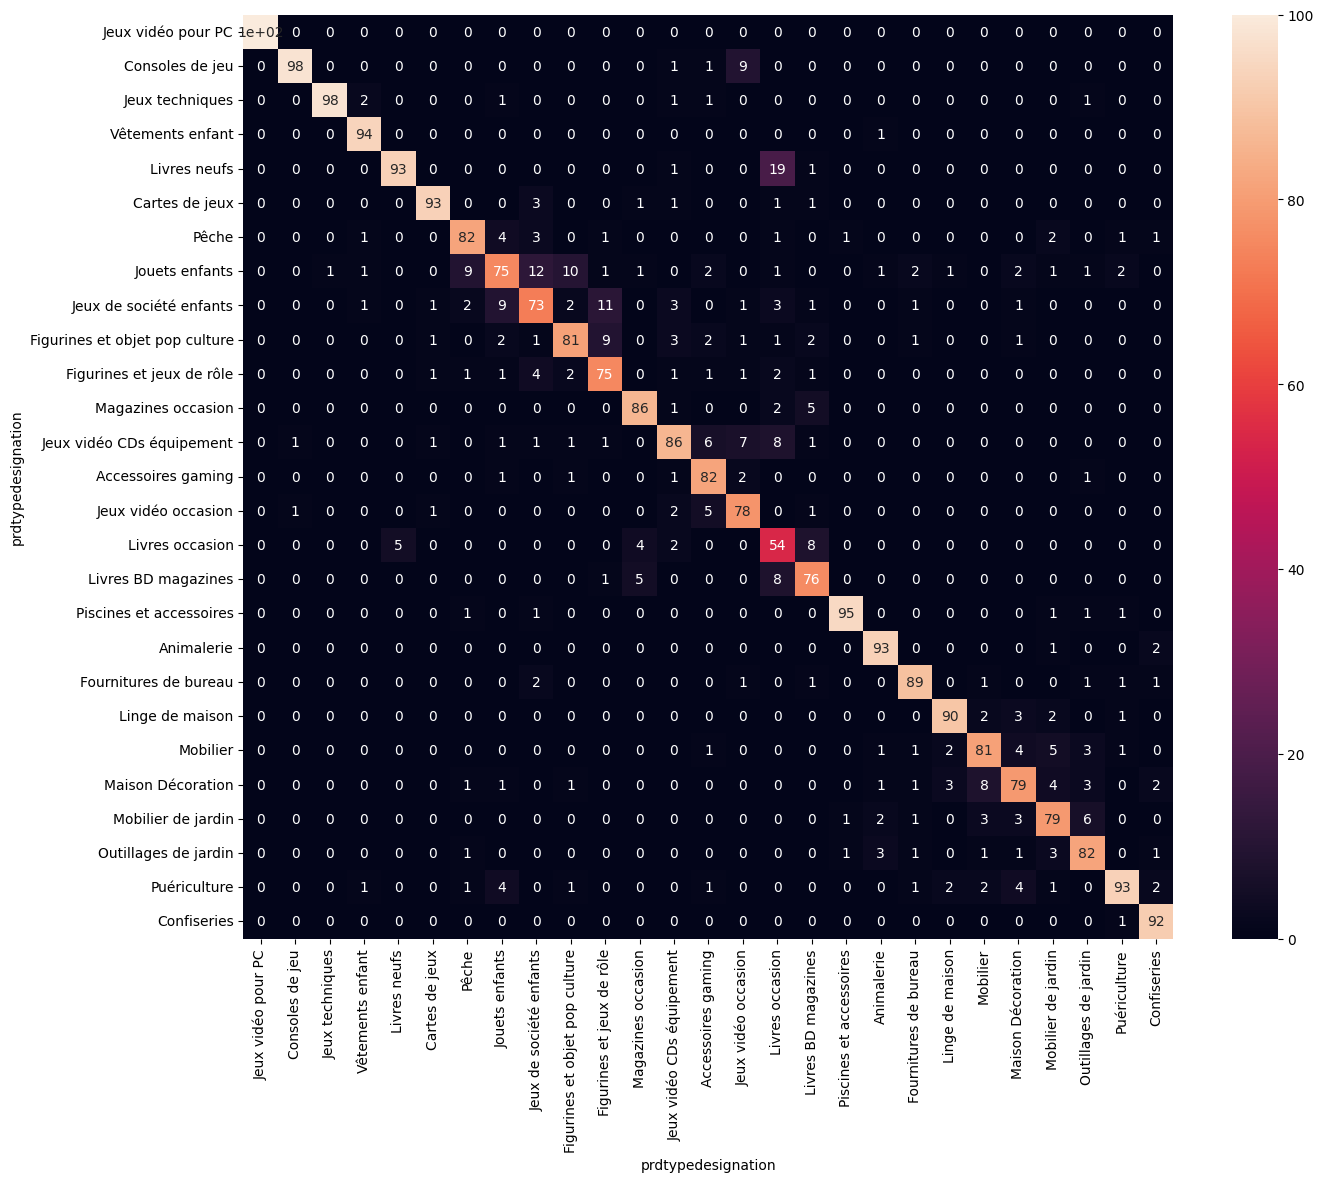

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [ ]:
plot_classification_results(y_test, y_txt_pred, index=class_labels['prdtypedesignation'])

## ViT classifier

In [5]:
callbacks = [('EarlyStopping', {'monitor': 'val_accuracy', 'mode': 'max', 'min_delta': 0.001, 'patience': 2, 'restore_best_weights': True})]
model_ViT = ImgClassifier(base_name='vit_b16', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=5, batch_size=32, learning_rate=5e-5)#, validation_split=0.1, callbacks=callbacks)
# model_resnet50 = ImgClassifier(base_name='ResNet50', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)
# model_vgg16 = ImgClassifier(base_name='VGG16', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)
# model_efficientNet = ImgClassifier(base_name='EfficientNetB1', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-09 16:52:45.588748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 16:52:45.589154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 16:52:45.650745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 16:52:45.650842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 16:52:45.650893: I external/local_xla/xla/stream_executor

In [ ]:
model_ViT.fit(X_train, y_train)
# model_resnet50.fit(X_train[:10000], y_train[:10000])
# model_vgg16.fit(X_train[:10000], y_train[:10000])
# model_efficientNet.fit(X_train[:10000], y_train[:10000])

Found 67932 validated image filenames.
Epoch 1/5
INFO:tensorflow:Collective all_reduce tensors: 202 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 202 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-03-08 02:22:45.486615: E tensorflow/core/common_runtime/base_collective_executor.cc:249] BaseCollectiveExecutor::StartAbort INVALID_ARGUMENT: Shape mismatch in the collective instance 100. Op at device /job:localhost/replica:0/task:0/device:GPU:0 expected shape [85900571] but another member in the group expected shape [171059971]. This is likely due to different input shapes at different members of the collective op.
2024-03-08 02:22:45.518415: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3630511815970329053
2024-03-08 02:22:45.518557: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2447318805362549498
2024-03-08 02:22:45.518592: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5163296947373776634
2024-03-08 02:22:45.518613: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_682030/4171310539.py", line 1, in <module>
    model_ViT.fit(X_train, y_train)
  File "/mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/image/classifiers.py", line 298, in fit
  File "/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node CollectiveReduceV2_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<

In [ ]:
model_ViT.classification_score(X_test, y_test)

Found 16984 validated image filenames.


2024-03-07 22:08:39.747653: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 22:08:39.872990: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 22:08:42.736270: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 112s 192ms/step


0.6768035057595863

In [ ]:
model_ViT.save(name='ViTb16_Ep5_lr5_10_5')
# model_efficientNet.save(name='EfficientNet_test')

In [ ]:
plot_training_history(model_ViT.history)

In [ ]:
classification_results(y_test, y_img_pred, index=class_labels['prdtypedesignation'])

              precision    recall  f1-score   support

           0       0.46      0.69      0.55       623
           1       0.68      0.72      0.70       534
           2       0.94      0.96      0.95       791
           3       0.64      0.41      0.50       153
           4       0.50      0.44      0.47       974
           5       0.43      0.27      0.33       414
           6       0.67      0.84      0.75      1009
           7       0.76      0.81      0.79       161
           8       0.58      0.46      0.51       498
           9       0.60      0.56      0.58       648
          10       0.69      0.58      0.63      1015
          11       0.84      0.84      0.84       861
          12       0.79      0.75      0.77       161
          13       0.54      0.58      0.56       999
          14       0.68      0.40      0.50       165
          15       0.81      0.79      0.80       952
          16       0.79      0.65      0.71       955
          17       0.78    

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

## Voting classifier with Bert and ViT

In [ ]:
from sklearn.ensemble import VotingClassifier

model_txt = TFbertClassifier(base_name='camembert-base', from_trained = 'Bert_test', max_length=256, num_class=27, drop_rate=0.2, epochs=0)
model_img = ImgClassifier(base_name='b16', from_trained = 'ViT_test', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, batch_size=32, learning_rate=5e-5, epochs=0)

voting_clf = VotingClassifier(estimators = [('txt_clf', model_txt), ('img_clf', model_img)], voting='soft', weights=[0.6, 0.4])
voting_clf.fit(X_train, y_train)

All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test


VotingClassifier(estimators=[('txt_clf',
                              TFbertClassifier(epochs=0,
                                               from_trained='Bert_test')),
                             ('img_clf',
                              ViTClassifier(augmentation_params={'cval': 255,
                                                                 'fill_mode': 'constant',
                                                                 'height_shift_range': 0.1,
                                                                 'horizontal_flip': True,
                                                                 'rotation_range': 20,
                                                                 'width_shift_range': 0.1},
                                            epochs=0,
                                            from_trained='ViT_test'))],
                 voting='soft', weights=[0.6, 0.4])

In [ ]:
voting_pred = voting_clf.predict(X_test)
f1_score(y_test, voting_pred, average='weighted')

2024-03-06 02:10:01.856308: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 154s 275ms/step
Found 16984 validated image filenames.


2024-03-06 02:12:36.438034: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 02:12:39.342531: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 140s 251ms/step


0.8585865972586947

## Stacking classifier with Bert and ViT

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

model_txt = TFbertClassifier(base_name='camembert-base', from_trained = 'Bert_test', max_length=256, num_class=27, drop_rate=0.2, epochs=0)
model_img = ImgClassifier(base_name='b16', from_trained = 'ViT_test', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, batch_size=32, learning_rate=5e-5, epochs=0)
final_clf = LogisticRegression(C=1.0, penalty='l2')

stacking_clf = StackingClassifier(estimators = [('txt_clf', model_txt), ('img_clf', model_img)], final_estimator=final_clf, cv='prefit', stack_method='predict_proba')
stacking_clf.fit(X_test, y_test)

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test
531/531 [==============================] - 148s 274ms/step
Found 16984 validated image filenames.


2024-03-06 08:50:07.369828: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 08:50:10.671323: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 137s 244ms/step


StackingClassifier(cv='prefit',
                   estimators=[('txt_clf',
                                TFbertClassifier(epochs=0,
                                                 from_trained='Bert_test')),
                               ('img_clf',
                                ViTClassifier(augmentation_params={'cval': 255,
                                                                   'fill_mode': 'constant',
                                                                   'height_shift_range': 0.1,
                                                                   'horizontal_flip': True,
                                                                   'rotation_range': 20,
                                                                   'width_shift_range': 0.1},
                                              epochs=0,
                                              from_trained='ViT_test'))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

In [ ]:
stacking_pred = stacking_clf.predict(X_test)
f1_score(y_test, stacking_pred, average='weighted')

531/531 [==============================] - 146s 274ms/step
Found 16984 validated image filenames.
531/531 [==============================] - 130s 245ms/step


0.868771593772429

## MultiModal transformer

In [5]:
def lrscheduler(epoch, lr):
  return lr * 0.5

callbacks = [('LearningRateScheduler', {'schedule': lrscheduler})]

model_multi = TFmultiClassifier(txt_base_name='camembert-base', img_base_name='vit_b16', 
                                 max_length=256, img_size=(224, 224, 3), augmentation_params=None,
                                 num_class=27, drop_rate=0.2, attention_numheads=8, transfo_numblocks=3,
                                 epochs=8, batch_size=32, learning_rate=5e-5, validation_data=(X_test, y_test), callbacks=callbacks)#, from_trained = {'text': 'Bert_ep8_lr5_10_5', 'image': 'ViTb16_Ep5_lr5_10_5_val10'}

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-09 23:57:03.330537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 23:57:03.330934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 23:57:03.411911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 23:57:03.412001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 23:57:03.412049: I external/local_xla/xla/stream_executor

In [6]:
model_multi.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 inputs (InputLayer)         [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 txt_base_layers (TFCamembe  TFBaseModelOutputWithPooli   1106219   ['attention_mask[0][0]',

In [7]:
model_multi.fit(X_train, y_train)

Found 32 validated image filenames.
Epoch 1/8
INFO:tensorflow:Collective all_reduce tensors: 462 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 3 all_reduces, num_devices =2, group_size = 2, implementation = CommunicationImplementation.NCCL
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 462 all_reduces, num_devices = 2, g

2024-03-10 00:00:41.542857: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 00:00:41.557604: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 00:00:41.934892: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 00:00:45.241937: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 00:00:48.385902: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff5401d6bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 00:00:48.386021: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-10 00:00:48.386043: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compu

2123/2123 [==============================] - ETA: 0s - loss: 0.7124 - accuracy: 0.7856INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated ima

TFmultiClassifier(augmentation_params={'cval': 255, 'fill_mode': 'constant',
                                       'height_shift_range': 0.1,
                                       'horizontal_flip': True,
                                       'rotation_range': 20,
                                       'width_shift_range': 0.1},
                  callbacks=[('LearningRateScheduler',
                              {'schedule': <function lrscheduler at 0x7ff787480ea0>})],
                  epochs=8, transfo_numblocks=3,
                  validation_data=(                                                  tokens  \
0      bas de filles pour les enfants enfants collant.....
16979  /home/jul/DST/Rakuten/Data/images/image_train_...  
16980  /home/jul/DST/Rakuten/Data/images/image_train_...  
16981  /home/jul/DST/Rakuten/Data/images/image_train_...  
16982  /home/jul/DST/Rakuten/Data/images/image_train_...  
16983  /home/jul/DST/Rakuten/Data/images/image_train_...  

[16984 rows x 2 columns],
                                   0         7
1        10
2        20
3         2
4        16
         ..
16979     4
16980    16
16981    22
16982    18
16983    20
Name: prdtypeindex, Length: 16984, dtype: int64))

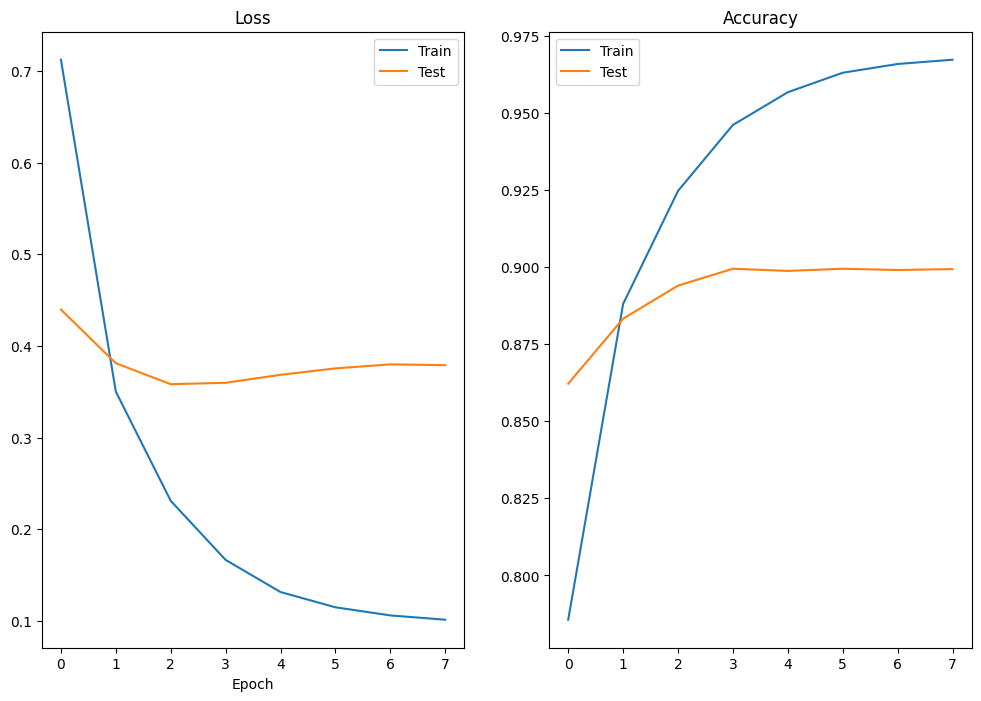

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [8]:
from src.utils.plot import plot_training_history

plot_training_history(model_multi.model.history)

In [9]:
model_multi.classification_score(X_test, y_test)

Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
  1/531 [..............................] - ETA: 2:06:56Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
531/531 [==============================] - 214s 377ms/step


0.8984291021435897

In [10]:
model_multi.save('Fusion_TF_Bert_ViT')